In [1]:
import pandas as pd
from os.path import join

In [2]:
DATA_DIR = 'data'
DATA_FILE_sequence = join(DATA_DIR,'ZSAC_ZVAC_Collaboration_sequence_data_20250124.csv')
DATA_FILE = join(DATA_DIR,'covid_data_2.csv')

In [3]:
REF_DATE = pd.to_datetime('2022-01-01')
target_col = 'final_outcome_amp'

In [4]:
SCALE = False
APPLY_PCA = False
FILTER_MI = False

In [5]:
REF_DATE = pd.to_datetime('2022-01-01')
def filter_data_date(data,reference_date = REF_DATE):
    '''For each person (record_id), get only the row with the visit date closest to reference_date'''
    data['visit_date'] = pd.to_datetime(data['visit_date'])
    data = data.dropna(subset=['visit_date'],ignore_index = True)
    data = data[data['visit_date'] < reference_date]
    return data.sort_values(by=['record_id','visit_date'],ascending = [True,False]).drop_duplicates(subset=['record_id'], keep='first')#.reset_index()

In [6]:
all_data = pd.read_csv(DATA_FILE)
raw_data = filter_data_date(all_data).dropna(axis=1, how='all') #apply date filter and remove empty columns
raw_data.pop('visit_date')
raw_data.set_index('record_id',inplace=True)
raw_data.columns = raw_data.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
assert (all_data['record_id'].unique() == raw_data.index).all()
all_data_sequence = pd.read_csv(DATA_FILE_sequence)
raw_data_sequence = all_data_sequence.dropna(axis=1, how='all') #aspply date filter and remove empty columns
raw_data_sequence.set_index('record_id',inplace=True)
raw_data_sequence.columns = raw_data_sequence.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
assert (raw_data_sequence.index == raw_data.index).all()
#y = raw_data.pop('final_outcome_amp')

In [ ]:
def scale(data):
    if SCALE: data = (data - data.mean())/data.std()
    return data
    
def preprocess_sequence_data(df):
    data = pd.get_dummies(df, columns=['sequence_cat'], dtype=int)
    data = pd.get_dummies(data, columns=['sequence'], dtype=int)
    data['days_between_lastexp'] = scale(df['days_between_lastexp'])
    data['days_betweentp'] = scale(df['days_betweentp'])
    data['behaviour_cat_2l_v2'] = data['behaviour_cat_2l_v2'].map({data['behaviour_cat_2l_v2'].unique()[0]:0,data['behaviour_cat_2l_v2'].unique()[1]:1})
    return data

def new_data(df):
    data = pd.DataFrame()
    data['study'] = df['study'].map({df['study'].unique()[0]:0,df['study'].unique()[1]:1})
    data['final_outcome_amp'] = df['final_outcome_amp']
    data['index_date'] = (REF_DATE - pd.to_datetime(df['index_date'], format='%Y-%m-%d')).dt.days

    most_recent_vaccine = df[['vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
    most_recent_vaccine = (REF_DATE - pd.to_datetime(most_recent_vaccine, format='%Y-%m-%d')).dt.days.fillna(700)

    most_recent_infection = df[['pcr_pos_date_2', 'pcr_pos_date_1']].bfill(axis=1).iloc[:, 0]
    most_recent_infection = (REF_DATE - pd.to_datetime(most_recent_infection, format='%Y-%m-%d')).dt.days.fillna(700)

    most_recent_contact = df[['pcr_pos_date_2', 'pcr_pos_date_1', 'vaccine_date_4', 'vaccine_date_3', 'vaccine_date_2', 'vaccine_date_1']].bfill(axis=1).iloc[:, 0]
    most_recent_contact = (REF_DATE - pd.to_datetime(most_recent_contact, format='%Y-%m-%d')).dt.days.fillna(700)

    #data['most_recent_vaccine'] = most_recent_vaccine
    #data['most_recent_infection'] = most_recent_infection
    #data['most_recent_contact'] = most_recent_contact

    pcr_pos_date = (REF_DATE - pd.to_datetime(df['pcr_pos_date_1'], format='%Y-%m-%d')).dt.days.fillna(-100)
    data['pcr_pos_date'] = pcr_pos_date
    data['age'] = scale(df['age'])
    data['bmi'] = scale(df['bmi'])
    data['bmi'] = data['bmi'].fillna(data['bmi'].mean())

    delta_t = (pd.to_datetime(df['pcr_pos_date_1'], format='%Y-%m-%d') - pd.to_datetime(df['vaccine_date_1'], format='%Y-%m-%d')).dt.days.fillna(500)
    #data['delta_t'] = delta_t
    data['comorbidity'] = df['comorbidity'].map({df['comorbidity'].unique()[0]:0,df['comorbidity'].unique()[1]:1})
    data['first_exposure_date'] = (REF_DATE - pd.to_datetime(df['first_exposure_date'], format='%Y-%m-%d')).dt.days.fillna(500)
    data['num_vaccines'] = raw_data[['vaccine_date_1', 'vaccine_date_2', 'vaccine_date_3', 'vaccine_date_4']].notna().sum(axis=1)

    data['ab_chuv_igg_s_logratio'] = scale(df['ab_chuv_igg_s_logratio'])
    data['ab_chuv_igg_n_logratio'] = scale(df['ab_chuv_igg_n_logratio'])
    data['ab_chuv_iga_logratio'] = scale(df['ab_chuv_iga_logratio'])
    data['first_exposure'] = df['first_exposure'].map({df['first_exposure'].unique()[0]:0,df['first_exposure'].unique()[1]:1}).fillna(0.5)
    data['prior_exposure'] = df['prior_exposure'].map({df['prior_exposure'].unique()[0]:0,df['prior_exposure'].unique()[1]:1}).fillna(0.5)
    data['last_antibody_before_omicron_igg_n_logratio'] = scale(df['last_antibody_before_omicron_igg_n_logratio'])
    return data

In [8]:
data_sequence =  preprocess_sequence_data(raw_data_sequence)
data = new_data(raw_data)
data = data.join(data_sequence, on='record_id', how='left')

In [9]:
print(f"Final dataset shape: {data.shape}")
print("\nMissing values:", data.isna().sum().sum())
print("Column dtypes:\n", data.dtypes.value_counts())
print("\nTarget distribution:\n", data['final_outcome_amp'].value_counts(normalize=True))

Final dataset shape: (710, 39)

Missing values: 0
Column dtypes:
 int64      29
float64    10
Name: count, dtype: int64

Target distribution:
 final_outcome_amp
0    0.628169
1    0.371831
Name: proportion, dtype: float64


# Machine Learning

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Stratified split to preserve class balance
X = data.drop('final_outcome_amp', axis=1)
X.columns = [str(col).replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in X.columns]
y = data['final_outcome_amp']

# Initial split (80% train/val, 20% test)

/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/hep/lprate/miniconda3/lib/python3.12/site-packages/sklearn/svm/_

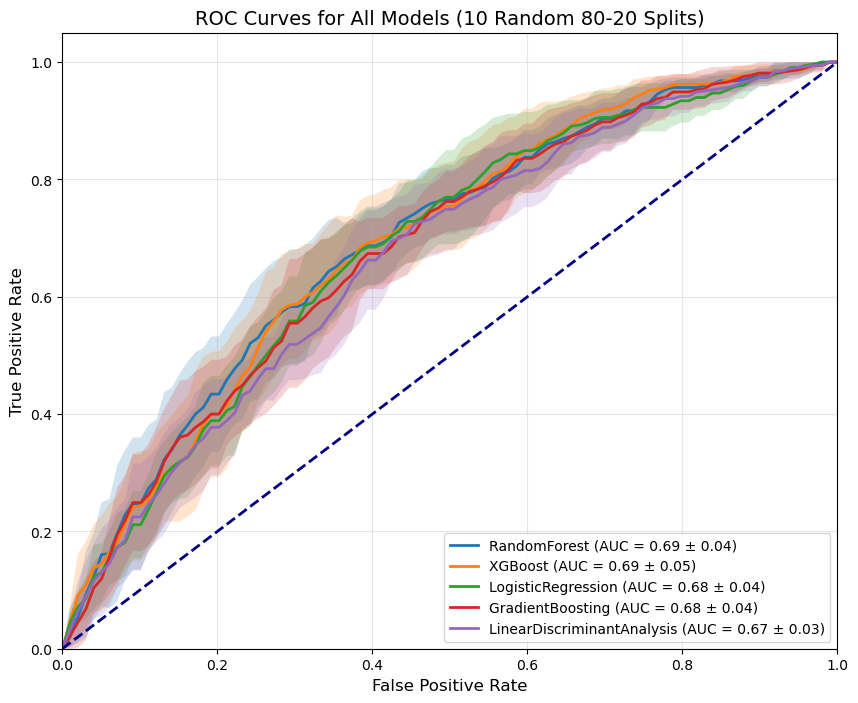


=== Optimal Hyperparameters ===

** RandomForest **
bootstrap: True
class_weight: balanced
max_depth: None
min_samples_leaf: 5
min_samples_split: 5
n_estimators: 20

** XGBoost **
learning_rate: 0.01
max_depth: 3
min_child_weight: 10
n_estimators: 200
reg_lambda: 1
scale_pos_weight: 1

** LogisticRegression **
C: 0.1
class_weight: balanced
penalty: l1

** GradientBoosting **
max_depth: 2
min_samples_leaf: 50

** LinearDiscriminantAnalysis **
shrinkage: 0.1
solver: lsqr
tol: 0.0001

=== Test Set Metrics (Last Split) ===

** RandomForest **
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        89
           1       0.52      0.55      0.53        53

    accuracy                           0.64       142
   macro avg       0.62      0.62      0.62       142
weighted avg       0.65      0.64      0.64       142

Confusion Matrix:
 [[62 27]
 [24 29]]

** XGBoost **
              precision    recall  f1-score   support

           0       

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import Counter

# Use stratified K-Fold for cross-validation (inner loop)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'bootstrap': [True, False],
            'n_estimators': [20, 100, 200, 500],
            'max_depth': [None, 10, 20, 40],
            'min_samples_split': [5, 7, 10, 12, 20, 50],
            'min_samples_leaf': [2, 5, 8],
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'param_grid': {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100, 200, 500],
            'max_depth': [3, 5],
            'reg_lambda': [0, 0.1, 1],
            'min_child_weight': [1, 3, 5, 10],  
            'scale_pos_weight': [1, (len(y)-sum(y))/sum(y)]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, solver='liblinear'),
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10],
            'class_weight': ['balanced', None]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'max_depth': [2, 5, 15, 20],
            'min_samples_leaf': [2, 25, 50],
        }
    },
    'LinearDiscriminantAnalysis': {
        'model': LinearDiscriminantAnalysis(),
        'param_grid': {
            'solver': ['svd', 'lsqr', 'eigen'],
            'shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
            'tol': [1e-4, 1e-3, 1e-2],
        }
    }
}

# Number of random train-test splits
n_splits = 10
test_size = 0.2  # 20% test set

plt.figure(figsize=(10, 8))
best_models = {}
accuracy_scores = {}
auc_scores = {}
balanced_accuracy_scores = {}
feature_importances = {}
optimal_parameters = {}  # Dictionary to store optimal parameters

for model_name, config in models.items():
    tprs = []
    aucs = []
    accuracies = []
    balanced_accuracies = []
    mean_fpr = np.linspace(0, 1, 100)
    optimal_parameters[model_name] = []  # Initialize list to store parameters from each split
    
    for split in range(n_splits):
        # Create random train-test split while preserving class distribution
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42+split, stratify=y
        )
        
        # Inner loop for GridSearchCV
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['param_grid'],
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Store optimal parameters for this split
        optimal_parameters[model_name].append(grid_search.best_params_)
        
        # Use best model from last split as the overall best model
        best_models[model_name] = best_model
        
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_test, y_proba))
        
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        
        # Save feature importances for RandomForest
        if model_name == 'RandomForest':
            if split == n_splits - 1:  # Save only from the last split
                feature_importances[model_name] = best_model.feature_importances_
                
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.2)
    
    accuracy_scores[model_name] = (np.mean(accuracies), np.std(accuracies))
    auc_scores[model_name] = (mean_auc, std_auc)
    balanced_accuracy_scores[model_name] = (np.mean(balanced_accuracies), np.std(balanced_accuracies))

# Plot formatting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for All Models (10 Random 80-20 Splits)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Print optimal hyperparameters for each model
print("\n=== Optimal Hyperparameters ===")
for model_name, params_list in optimal_parameters.items():
    print(f"\n** {model_name} **")
    
    # Create a summary of parameter frequency across splits
    # For each parameter, find the most common value
    param_summary = {}
    for param_name in params_list[0].keys():
        param_values = [split_params[param_name] for split_params in params_list]
        value_counts = Counter(param_values)
        most_common_value = value_counts.most_common(1)[0][0]
        param_summary[param_name] = most_common_value
    
    # Print the most common parameter values
    for param, value in param_summary.items():
        print(f"{param}: {value}")

# Print test set metrics for the last split
print("\n=== Test Set Metrics (Last Split) ===")
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n** {model_name} **")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print accuracy and balanced accuracy across all splits
print("\n=== Accuracy and Balanced Accuracy (All Splits) ===")
for model_name in models.keys():
    acc_mean, acc_std = accuracy_scores[model_name]
    bal_acc_mean, bal_acc_std = balanced_accuracy_scores[model_name]
    print(f"\n** {model_name} **")
    print(f"Accuracy: {acc_mean:.2f} ± {acc_std:.2f}")
    print(f"Balanced Accuracy: {bal_acc_mean:.2f} ± {bal_acc_std:.2f}")

# Print feature importances for RandomForest (from the last split)
if 'RandomForest' in feature_importances:
    print("\n=== Feature Importances for RandomForest (Last Split) ===")
    feature_importance_dict = dict(zip(X.columns, feature_importances['RandomForest']))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    for feature, importance in sorted_features:
        print(f"{feature}: {importance:.4f}")

In [12]:
auc_scores

{'RandomForest': (0.6949332202671189, 0.04120011395588271),
 'XGBoost': (0.6924316302734789, 0.04632361448751159),
 'LogisticRegression': (0.6832096671613315, 0.03850082624187841),
 'GradientBoosting': (0.6815454738181048, 0.043600089327744174),
 'LinearDiscriminantAnalysis': (0.6686665253338987, 0.03407710137542093)}